# Plot Tracts and Patches

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/22
- update : 2024/02/23


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+34187316c4 	current w_2024_07 setup


In [3]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize


from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
#%matplotlib widget
%matplotlib inline

# default plot style is accessible
plt.style.use('tableau-colorblind10')

In [4]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [5]:
list(butler.registry.queryDimensionRecords('detector', where="instrument='LATISS' AND detector.id IN (0..8)"))

[detector.RecordClass(instrument='LATISS', id=0, full_name='RXX_S00', name_in_raft='RXX_S00', raft=None, purpose='SCIENCE')]

### access to skymap

https://github.com/sylvielsstfr/MyDP0LSS/blob/main/myDP0.2/TrackAndPatch/PlotTractAndPatchs_butler.ipynb

In [6]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [7]:
datasetRefs = butler.registry.queryDatasets(datasetType='skyMap', collections=my_collection, where= "instrument='LATISS'")

In [8]:
for i, ref in enumerate(datasetRefs):
    pprint(ref)
    skymap_id = ref.dataId["skymap"]
    if skymap_id ==  'latiss_v1':
        skymap = ref

DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'hsc_rings_v1'}, run='skymaps', id=6e7fc928-0dc3-4e1b-ae63-5fb63be46216)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'latiss_v1'}, run='skymaps', id=f677ff86-2b1c-4094-9dad-e39395052cd1)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'lsst_cells_v1'}, run='skymaps', id=857e0e80-8d08-44f4-a81b-84227b064d5b)


In [9]:
skymap = butler.get(ref)

In [10]:
#my_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]
my_tracts = [382,383,452,455,
                     3863,3864,
                     5614,5615,5616,5634,5839,
                     #8188,
                     10643,10644]

In [11]:
#from lsst.daf.butler import Butler
#butler = Butler('SMALL_HSC')
skymap = butler.get('skyMap', skymap='latiss_v1', collections=my_collection)
tractInfo = skymap.generateTract(5616)
#patch = tractInfo[41]
#patch.getIndex()

In [12]:
skymap.generateTract?

Signature: skymap.generateTract(index)
Docstring: Generate TractInfo for the specified tract index.
File:      /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/skymap/ga8c6da7877+ef8d675bea/python/lsst/skymap/ringsSkyMap.py
Type:      method

In [13]:
#for patch in tractInfo:
#    print(patch.getSequentialIndex())

In [14]:
#patch.getSequentialIndex?

In [15]:
# Load data (deserialize)
import pickle
#with open('Latiss_tractspatchs.pickle', 'rb') as handle:
with open('../data/202402/Latiss_tractspatchs_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [16]:
tracts_patchs_dict

{10644: array([189, 183, 184, 164, 185, 203, 201, 207, 182, 162, 166, 165, 181,
        161, 188, 208, 180, 202]),
 5634: array([ 90, 110,  71, 112,  73, 109,  93,  92,  91,  53,  72,  55,  52,
        111,  54,  74]),
 3863: array([223, 261, 241, 242, 262, 260, 243, 222, 224]),
 452: array([41, 62, 22, 25, 23, 44, 42, 63, 43, 24]),
 5614: array([250, 251, 230, 210, 212, 232, 211, 213, 249, 229, 231]),
 5616: array([355, 358, 316, 338, 356, 336, 357, 337, 317, 335, 315, 334]),
 5615: array([274, 331, 312, 332, 294, 295, 293, 313, 333, 314, 275, 276]),
 5839: array([9, 8, 7]),
 10643: array([190, 171]),
 455: array([51, 52, 15, 33, 14, 53, 34, 13, 32]),
 382: array([343, 344, 342]),
 3864: array([274, 238, 217, 218, 273, 255, 235, 275, 237, 257, 219, 236, 256,
        254, 276, 216]),
 383: array([359, 360])}

In [17]:
list_of_tracts = list(tracts_patchs_dict.keys())
list_of_tracts

[10644, 5634, 3863, 452, 5614, 5616, 5615, 5839, 10643, 455, 382, 3864, 383]

In [18]:
npatches = 0
for itract in list_of_tracts:
    npatches += len(tracts_patchs_dict[itract])
print(npatches)    

123


In [19]:
#corners = np.array([ (ll[0], ll[1]), 
#                    (ul[0], ul[1] ), 
#                    (ur[0], ur[1]), 
#                    (lr[0], lr[1])])

===1===tractId:patchId = 382:342==========
corners =  [[ 12.69437584 -72.91024487]
 [ 12.4111962  -72.91379092]
 [ 12.39980658 -72.83057359]
 [ 12.6816523  -72.82704592]
 [ 12.69437584 -72.91024487]]
===1===tractId:patchId = 382:343==========
corners =  [[ 12.41110175 -72.91379204]
 [ 12.12780416 -72.91694484]
 [ 12.11775058 -72.83371115]
 [ 12.39971258 -72.8305747 ]
 [ 12.41110175 -72.91379204]]
===1===tractId:patchId = 382:344==========
corners =  [[ 12.12770968 -72.91694583]
 [ 11.84430792 -72.91970512]
 [ 11.83559184 -72.83645711]
 [ 12.11765654 -72.83371214]
 [ 12.12770968 -72.91694583]]
===2===tractId:patchId = 383:359==========
corners =  [[ 12.87210136 -72.91694386]
 [ 12.5888038  -72.91379092]
 [ 12.60019342 -72.83057359]
 [ 12.88215539 -72.83371017]
 [ 12.87210136 -72.91694386]]
===2===tractId:patchId = 383:360==========
corners =  [[ 12.58870936 -72.9137898 ]
 [ 12.30552976 -72.91024362]
 [ 12.31825374 -72.82704468]
 [ 12.60009942 -72.83057248]
 [ 12.58870936 -72.9137898 ]]


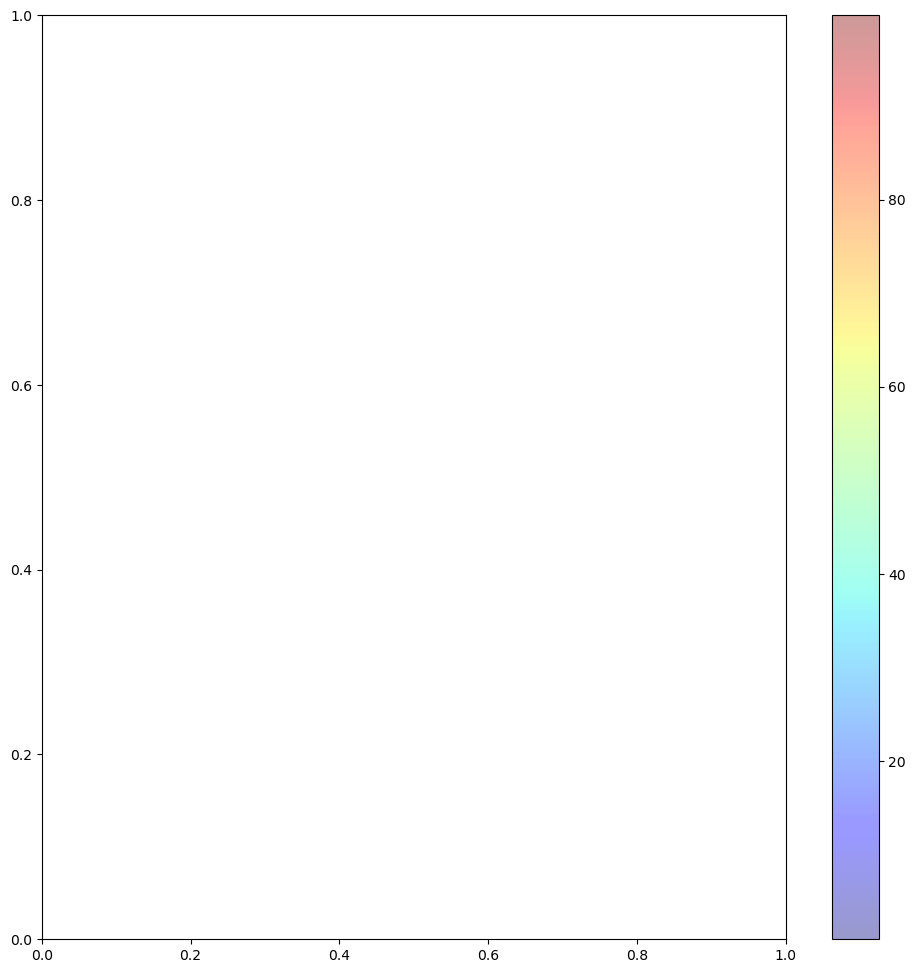

In [20]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

numTracts=0
# collection of polygons
patches = []
all_ra = []
all_dec = []
for tractInfo in skymap:
    tractID = tractInfo.getId()
    if tractID not in list_of_tracts:
        continue
    # Work with the new tract    
    numTracts+=1
    all_xvals = []
    all_yvals = []
    for patch in tractInfo:
        patchID = patch.getSequentialIndex()
        if patchID not in tracts_patchs_dict[tractID]:
            continue
        ibb=patch.getInnerBBox()
        tWCS=tractInfo.getWcs()
        corners = []
        # loop on the 4 corners
        for icorn,corner in enumerate(ibb.getCorners()):
            p = geom.Point2D(corner.getX(), corner.getY())
            coord = tWCS.pixelToSky(p)
            corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
            all_ra.append(coord.getRa().asDegrees()) 
            all_dec.append(coord.getDec().asDegrees()) 
        print(f"==={numTracts}===tractId:patchId = {tractID}:{patchID}==========")    
        corners_array = np.array(corners)
        corners_array = np.append(corners_array,[corners_array[0]],axis=0)
        print("corners = ",corners_array)
        polygon = Polygon(corners_array,closed=True)
        patches.append(polygon)
print(numTracts)   

# we can see this, not my polugons ???
#num_polygons = 5
#num_sides = 4
#for i in range(num_polygons):
#    polygon = Polygon(10*(np.random.rand(num_sides ,2)-0.5), True)
#    patches.append(polygon)



fig, ax = plt.subplots(figsize=(12,12))
p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))
#p.set_clim([5, 50])
ax.add_collection(p)  
fig.colorbar(p)

#ax.set_xlim([0., 60.])
#ax.set_ylim([-90, -30.])
fig.show()

In [21]:
all_ra = np.array(all_ra)
all_dec = np.array(all_dec)

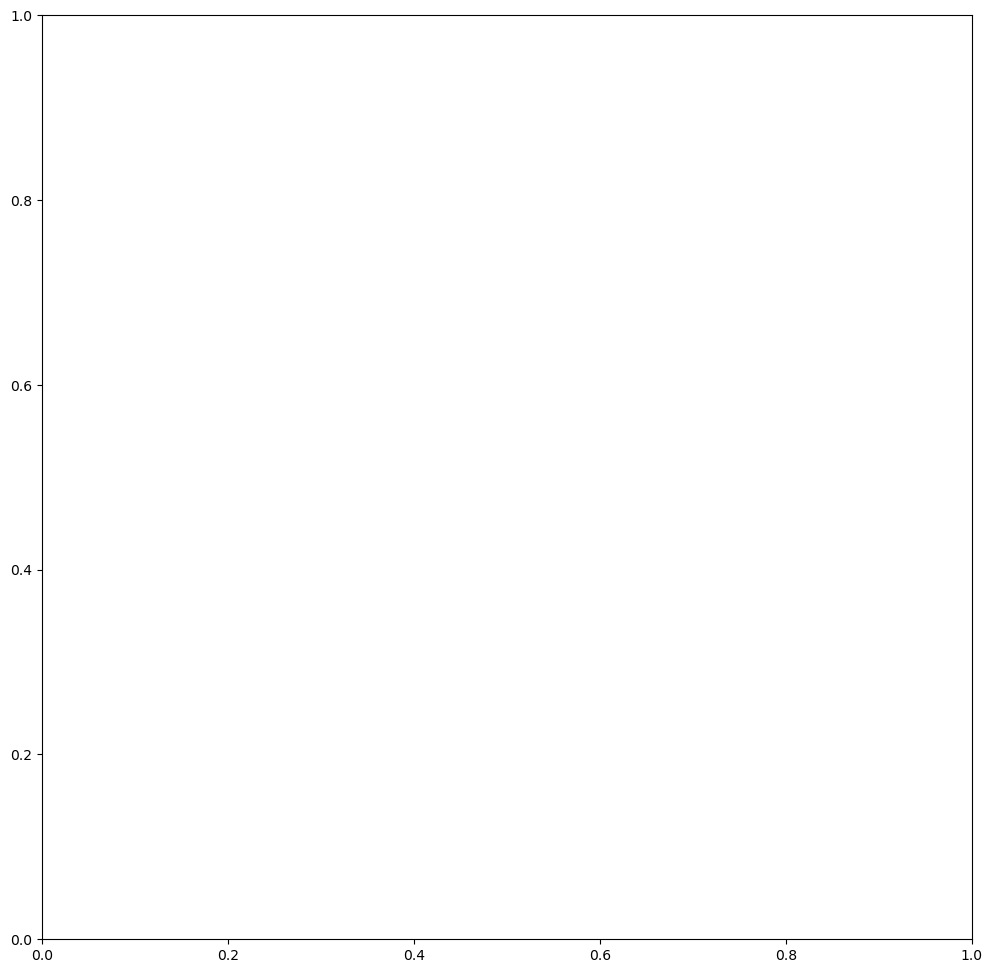

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)

colors = 50*np.random.rand(len(patches))
p.set_array(np.array(colors))
p.set_clim([5, 50])
ax.add_collection(p)  


#ax.set_xlim([0., 360.])
#ax.set_ylim([-90, 10.])
plt.show()

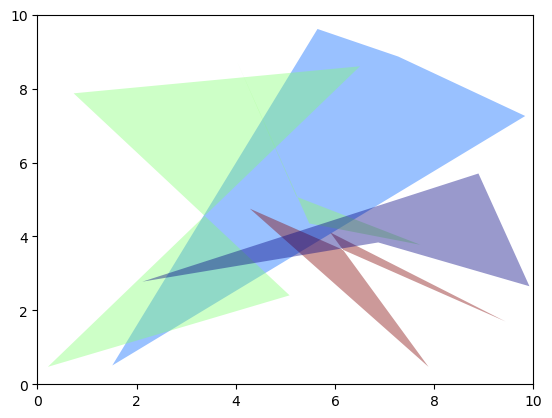

In [23]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
patches = []
num_polygons = 5
num_sides = 4

for i in range(num_polygons):
    polygon = Polygon(10*np.random.rand(num_sides ,2), closed=True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)

ax.set_xlim([0., 10.])
ax.set_ylim([0., 10.])

plt.show()